In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys

# sys.path.insert(0, "/home/jovyan/juart/src")

import matplotlib.pyplot as plt
import torch
import zarr

from juart.conopt.linops.channel import ChannelOperator
from juart.conopt.linops.fourier import FourierTransformOperator
from juart.recon.mirage import MIRAGE
from juart.recon.sense import SENSE
from juart.vis import MultiPlotter

torch.set_num_threads(24)

In [2]:
full_zarr_preproc_fname = "/workspaces/juart/LocalData/CS_MP2RAGE/preproc.zarr"

In [3]:
store = zarr.storage.LocalStore(full_zarr_preproc_fname)

In [4]:
group = zarr.open_group(store, path="preproc.zarr", mode="r")

In [5]:
# slc = slice(144, 145)
slc = slice(175, 176)
# slc = slice(200, 201)

In [6]:
coil_sensitivities = group["C"][..., slc]
sampling_mask = group["H"][...][None, :, :, None, None, :, :]
kspace_data = group["d"][..., slc, :, :] / 1e-3

In [7]:
coil_sensitivities = torch.tensor(coil_sensitivities, dtype=torch.complex64)
sampling_mask = torch.tensor(sampling_mask, dtype=torch.float32)
kspace_data = torch.tensor(kspace_data, dtype=torch.complex64)

In [8]:
print(coil_sensitivities.shape)
print(sampling_mask.shape)
print(kspace_data.shape)

torch.Size([8, 360, 288, 1, 1])
torch.Size([1, 360, 288, 1, 1, 2, 1])
torch.Size([8, 360, 288, 1, 1, 2, 1])


In [9]:
num_channels = 8
shape = 360, 288, 1, 1, 2, 1

In [10]:
C = ChannelOperator(
    coil_sensitivities,
    shape,
)

In [11]:
F = FourierTransformOperator(
    (num_channels,) + shape,
    (1, 2),
)

In [12]:
d = kspace_data.ravel().view(torch.float32)
AHd = C.H @ F.H @ d
regridded_data = AHd.view(torch.complex64).reshape(shape)

In [13]:
sense = SENSE(
    coil_sensitivities,
    regridded_data,
    sampling_mask,
    maxiter=15,
    verbose=True
)

In [14]:
x_sense = sense.solve()

[CG] Iter: 14 Res: 3.78E-03 : 100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


In [15]:
x_image = x_sense.view(torch.complex64).reshape(shape)

In [16]:
mirage = MIRAGE(
    coil_sensitivities,
    regridded_data,
    sampling_mask,
    lambda_wavelet=1e-3,
    weight_wavelet=0.5,
    cg_maxiter=5,
    admm_maxiter=50,
    verbose=True,
)

[ADMM] Initialization done.


In [17]:
z = mirage.solve()

[ADMM] Iter: 00 Prim Res: 3.44E+01 Dual Res: 3.44E+01 Rel Res: 1.00E+00 
[ADMM] Iter: 01 Prim Res: 2.70E+01 Dual Res: 7.50E+00 Rel Res: 9.66E-01 
[ADMM] Iter: 02 Prim Res: 5.68E+00 Dual Res: 2.04E+00 Rel Res: 8.62E-01 
[ADMM] Iter: 03 Prim Res: 1.33E+00 Dual Res: 8.56E-01 Rel Res: 7.07E-01 
[ADMM] Iter: 04 Prim Res: 4.12E-01 Dual Res: 5.00E-01 Rel Res: 5.77E-01 
[ADMM] Iter: 05 Prim Res: 1.82E-01 Dual Res: 3.38E-01 Rel Res: 4.68E-01 
[ADMM] Iter: 06 Prim Res: 1.01E-01 Dual Res: 2.47E-01 Rel Res: 3.79E-01 
[ADMM] Iter: 07 Prim Res: 6.30E-02 Dual Res: 1.90E-01 Rel Res: 3.09E-01 
[ADMM] Iter: 08 Prim Res: 4.23E-02 Dual Res: 1.51E-01 Rel Res: 2.55E-01 
[ADMM] Iter: 09 Prim Res: 3.00E-02 Dual Res: 1.24E-01 Rel Res: 2.14E-01 
[ADMM] Iter: 10 Prim Res: 2.23E-02 Dual Res: 1.03E-01 Rel Res: 1.81E-01 
[ADMM] Iter: 11 Prim Res: 1.72E-02 Dual Res: 8.75E-02 Rel Res: 1.55E-01 
[ADMM] Iter: 12 Prim Res: 1.36E-02 Dual Res: 7.52E-02 Rel Res: 1.35E-01 
[ADMM] Iter: 13 Prim Res: 1.11E-02 Dual Res: 6.53E-

In [18]:
z_image = z.view(torch.complex64).reshape(shape)

In [19]:
def compute_uni_image(x):
    return torch.real(torch.conj(x[..., 0, 0]) * x[..., 1, 0]) / (
        torch.abs(x[..., 0, 0]) ** 2 + torch.abs(x[..., 1, 0]) ** 2
    )

In [20]:
uni_image_regridded = compute_uni_image(regridded_data)

In [21]:
uni_image_x = compute_uni_image(x_image)

In [22]:
uni_image_z = compute_uni_image(z_image)

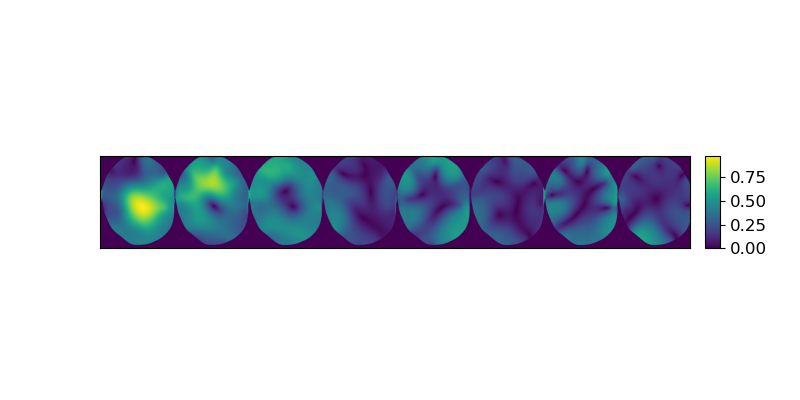

In [23]:
MultiPlotter(
    torch.abs(coil_sensitivities).cpu(),
    (1, 8),
    (0, 3, 4),
    cmap="viridis",
    fig=plt.figure(figsize=(8, 4)),
    cbar_pad="2.5%",
    cbar_size="2.5%",
)

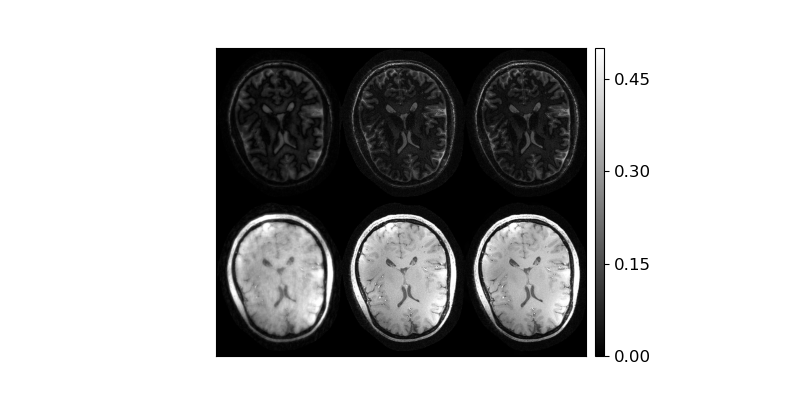

In [24]:
MultiPlotter(
    [
        torch.abs(regridded_data).cpu(),
        torch.abs(x_image).cpu(),
        torch.abs(z_image).cpu(),
    ],
    (2, 3),
    (3, 4, 5, 6, 0),
    cmap="gray",
    fig=plt.figure(figsize=(8, 4)),
    cbar_pad="2.5%",
    cbar_size="2.5%",
    vmin=0,
    vmax=0.5,
)

Zero filled - CG (Sense) - L1 Norm

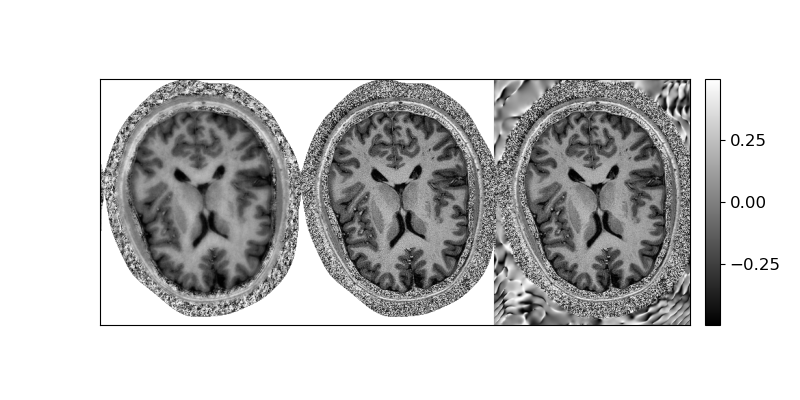

In [25]:
MultiPlotter(
    [uni_image_regridded.cpu(), uni_image_x.cpu(), uni_image_z.cpu()],
    (1, 3),
    (0, 3, 4),
    cmap="gray",
    fig=plt.figure(figsize=(8, 4)),
    cbar_pad="2.5%",
    cbar_size="2.5%",
)

In [26]:
# import twixtools.twixtools as twixtools
# twix = twixtools.read_twix('/workspaces/juart/LocalData/CS_MP2RAGE/twix/meas_MID00101_FID125842_CS_MP2RAGE_0_6mm_proposedTiming.dat')

In [27]:
# twix[-1]['hdr']

In [28]:
import numpy as np
from dicom_handling.load_dcm_dir import load_dcm_dir, extract_coil_info, convert_df_to_np_using_coilindices

In [29]:
ProjectPath = '/workspaces/juart/LocalData/CS_MP2RAGE/DICOM'
SeriesFolder = 'CS_MP2RAGE_0_6MM_PROPOSEDTIMING_RR_UNI_IMAGES_0005'
DicomDir = os.path.join(ProjectPath, SeriesFolder)
FileNamePattern = '*.IMA'

In [30]:
SeriesDescriptionPattern = '*'
HeaderFieldsToStore =  ['SeriesNumber', 'SeriesDescription', 'PixelSpacing', 'Rows', 'Columns', 'SliceLocation',
                        'ImageType', 'BitsStored', 'RescaleIntercept', (0x0028,0x1053),
                        (0x0029, 0x1020), (0x0051,0x100F) ]
UNI_DEN = load_dcm_dir(DicomDir, FileNamePattern, SeriesDescriptionPattern, HeaderFieldsToStore)

Found 288 matching DICOM files


In [31]:
# Sort by slice location
UNI_DEN.sort_values(by=['SliceLocation'],inplace=True)

In [32]:
# extract information on TX and RX coil elements
UNI_DEN_new = extract_coil_info(UNI_DEN)

TX Coil information has been added for 288 entries
RX Coil information has been added for 288 entries


In [33]:
# Create numoy array of images with dimensions
#    (NumberSequences, NTXCoils, NRXCoils, MatrixSize1, MatrixSize2)
np_UNI_DEN = convert_df_to_np_using_coilindices( UNI_DEN_new )

Found 8 Tx eleemnts in the array.
Combined images only.
Matrix size of images is 384 x 360.
Found 288 images per Rx element.


In [35]:
uni_image_dicom = np.fliplr(np.flipud(np.abs(np_UNI_DEN[:,0,0,np_UNI_DEN.shape[3]-slc.stop+12,:]).T))
uni_image_dicom = uni_image_dicom / np.max(uni_image_dicom[:]) - 0.5
uni_image_dicom = uni_image_dicom[:, :, np.newaxis, np.newaxis]

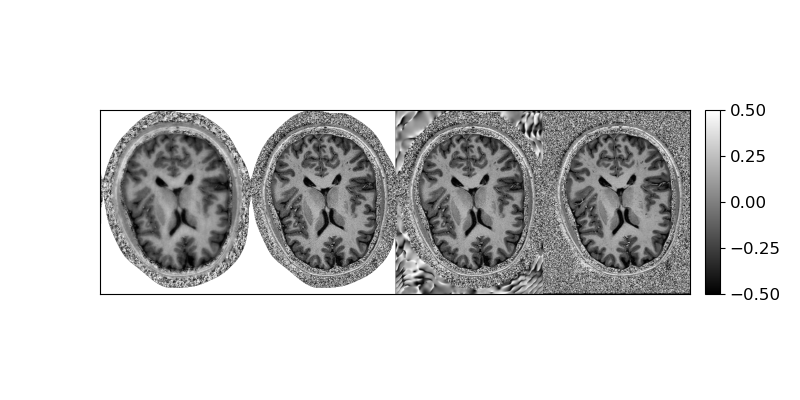

In [36]:
MultiPlotter(
    [uni_image_regridded.cpu(), uni_image_x.cpu(), uni_image_z.cpu(), uni_image_dicom],
    (1, 4),
    (0, 3, 4),
    cmap="gray",
    fig=plt.figure(figsize=(8, 4)),
    cbar_pad="2.5%",
    cbar_size="2.5%",
)